In [1]:
!pip install -q geopandas
!apt install -q proj-bin libproj-dev libgeos-dev -y
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip
!pip install -q rasterio

# Pandas is a package containing additional functions to use data frames in Python
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import warnings
import rasterio
import rasterio.features
import numpy as np
import seaborn as sns
import shapely
import os
import copy
warnings.simplefilter('ignore')
# These two lines allow the notebook to access the Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# This is the path to the project folder within the Google Drive.
file_path = "/content/drive/My Drive/"

%load_ext rpy2.ipython
from rpy2.robjects import pandas2ri  # activate pandas R  interface
pandas2ri.activate()

Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


In [2]:
def convert_xy_to_longlat(grid_x, grid_y):
  lon = ((grid_x / 6) - 180)
  lat = -((grid_y / 6) - 90)
  return (lon, lat)

def convert_longlat_to_xy(lon, lat):
  grid_x = int((lon + 180) * 6)
  grid_y = int((-lat + 90) * 6)
  return (grid_x, grid_y)

---
## Notebook 13
# Generating Absence Data

For some species distribution models, we need "pseudo absence" data - this is data for point in the world where the species is not found, which we can compare to places where it is found.

It is difficult to verify experimentally if a species is not present in a region - it's much easier to say the species is definitely there than that it definitely isn't there.

Instead, we generate random points where the species is assumed not to be present, as it has never been observed there.

This data needs to be realistic points where other similar species have been observed in the past and within a similar geographic area to the observation points.

To generate this data we'll use the following steps:

* Divide species into ants, bees, wasps, ticks and mites.  I have merged sawflies into wasps, as they are very similar

* Divide geographical regions by continent, excluding Antarctica.

* Extract the subset of observations for each combination of continent and species type (unless there are no observations for the combination).

* For each of our study species, loop through every continent where the species lives

* Generate a set of random points on the same continent, in regions where individuals of that type (e.g. ant) but not species (e.g. Lasius niger) have been observed.

* These points are "padded" to give us more points to work with, adding 10 x and y grid squares on either side of each possible absence point.





First, we read in a shapefile showing the location of each continent, so that we can automatically assign observation points to the correct continent - source https://www.arcgis.com/home/item.html?id=5cf4f223c4a642eb9aa7ae1216a04372

In [3]:
worldmap = gpd.read_file(file_path + "/continent_shapefile/continent.shp", index_col=0)
worldmap = worldmap.to_crs('epsg:4088')
worldmap = worldmap[worldmap['CONTINENT'] != 'Antarctica']
worldmap.index = worldmap['CONTINENT']
continents = dict(zip(worldmap['CONTINENT'], worldmap['geometry']))
worldmap['geometry'] = worldmap['geometry'].simplify(tolerance=0.15)

We also read the list of species which we have observations for.

In [4]:
species_list = [line.strip() for line in open(file_path + "species_names.tsv")]

To find out the "type" of each species we read the final summary table we generated in the data cleaning / georeferencing step and convert these into a dictionary.

In [5]:
summary_tab = pd.read_csv(file_path + "final_summary_all_tables/" + "final_summary_all.tsv", sep="\t")
typeD = dict(zip(summary_tab['species_name'], summary_tab['Type'].str.strip().str.capitalize()))

# Merge the "Sawfly" species into the "Wasp" category.
for key, val in typeD.items():
  if typeD[key] == 'Sawfly':
    typeD[key] = 'Wasp'

Store the grid shape of the rasters.

In [6]:
grid_shape = ((930, 2160))

Then we run through the species types (ant, wasp, bee, mite, tick) and find all the observation points for that type for any species, and store them in a dictionary.

In [7]:
# make an empty dictionary to store the grids
gridD = dict()
# seperate each continent
for continent in continents:
  # set the default dictionary value
  gridD.setdefault(continent, dict())
  for species in species_list:
    if species in typeD:
      # find out which type of species it is
      species_type = typeD[species]
      # check there is an observation table for this species
      if os.path.exists(file_path + "species_plus_climate_observed_geo/" + species + ".tsv"):

          # read the observation table
          obs_geo = pd.read_csv(file_path + "species_plus_climate_observed_geo/" + species + ".tsv", sep="\t")
          
          # filter to keep only this continent
          cont_obs = obs_geo[obs_geo['Continent'] == continent]

          # if there are observations for this species on this continent
          if len(cont_obs) != 0:
            # start each species type and continent with an empty grid of 0s
            gridD[continent].setdefault(species_type, np.zeros(grid_shape))

            # generate 10 x and 10 y coordinates surrounding each observation
            # co-ordinate
            xs = []
            ys = []
            xs += [np.arange(x - 10,  x + 10) for x in cont_obs['x']]
            ys += [np.arange(y - 10, y + 10) for y in cont_obs['y']]

            # convert these to numpy arrays
            xs = np.array(xs)
            ys = np.array(ys)
          
            # replace values which are outside the area of the grid
            xs[xs < 0] = 0
            xs[xs > 2100] = 2100
            ys[ys < 0] = 0
            ys[ys > 930] = 930

            # add a one to the observation grid everywhere this species
            # was observed
            gridD[continent][species_type][ys, xs] = 1

Check they look as expected - the absence data should be points on a specific continent distributed randomly within the known range of this species type.

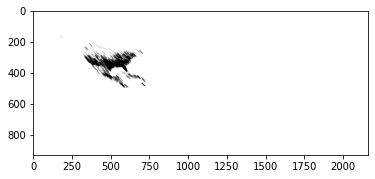

In [8]:
plt.imshow(gridD['North America']['Ant'], cmap='binary')

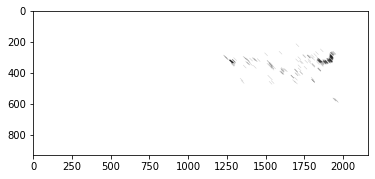

In [9]:
plt.imshow(gridD['Asia']['Mite'], cmap='binary')

From these datasets, for each species we want to generate a random set of absence points, the same size as the set of presence points for this species.

In [10]:
# Dictionaries to store the results in various formats
absenceD = dict()
absenceG = dict()
presenceG = dict()

for species in species_list:
  absenceD.setdefault(species, dict())
  absenceG.setdefault(species, dict())
  presenceG.setdefault(species, dict())
  for continent in continents:
      if species in typeD:
        # if there is observed data for this species and continent
        if os.path.exists(file_path + "species_plus_climate_observed_geo/" + species + ".tsv"):
            # get the species type
            species_type = typeD[species]

            # get the observed data for this continent only
            obs_geo = pd.read_csv(file_path + "species_plus_climate_observed_geo/" + species + ".tsv", sep="\t")
            cont_obs = obs_geo[obs_geo['Continent'] == continent]
            if len(cont_obs) != 0:

              # get all the possible absence points for this species type
              type_grid = copy.copy(gridD[continent][species_type])

              # get the observed presence points for this specific species
              xs = []
              ys = []

              # pad the observed points by 10 squares on either side so we're
              # not placing an absence point too close to a presence point
              xs += [np.arange(x - 20,  x + 20) for x in cont_obs['x']]
              ys += [np.arange(y - 20, y + 20) for y in cont_obs['y']]

              xs = np.array(xs)
              ys = np.array(ys)
            
              # remove points outside the grid boundaries
              xs[xs < 0] = 0
              xs[xs > 2100] = 2100
              ys[ys < 0] = 0
              ys[ys > 930] = 930

              # remove these points from the list of possible absence points
              type_grid[ys, xs] = 0

              # find the co-ordinates of the points for the remaining species
              # of this type
              remaining_absence = np.where(type_grid == 1)

              # if there are any points left - otherwise we can't have
              # absence data for this species and continent
              if sum(sum(remaining_absence)) != 0:
                # take a random sample of these co-ordinates
                # the random sample is the same size as the list of presence
                # points
                sample = np.random.choice(np.arange(np.shape(remaining_absence)[1]), len(obs_geo))
                absence_x = remaining_absence[0][sample]
                absence_y = remaining_absence[1][sample]
                absence_coords = absence_x, absence_y
                
                # store the co-ordinates of the absence points
                absenceD[species][continent] = absence_coords
                
                # store a grid of the absence points
                new_grid = np.zeros(np.shape(type_grid))
                new_grid[ys, xs] = 1
                absenceG[species][continent] = new_grid

                # store a grid of the presence points, just for comparison
                presence = np.zeros(np.shape(type_grid))
                presence[cont_obs['y'], cont_obs['x']] = 1
                presenceG[species][continent] = presence

Look at a couple to check the look normal - the dots should be different but in a similar region, the absence point should usually be more dispered.

Text(0.5, 1.0, 'Bombus terrestris presence Europe')

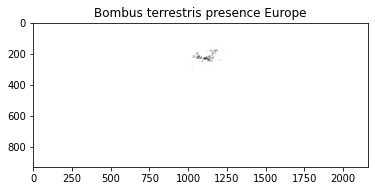

In [11]:
plt.imshow(presenceG['Bombus_terrestris']['Europe'], cmap='binary')
plt.title("Bombus terrestris presence Europe")

Text(0.5, 1.0, 'Bombus terrestris absence Europe')

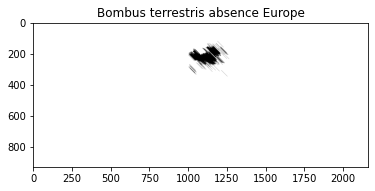

In [12]:
plt.imshow(absenceG['Bombus_terrestris']['Europe'], cmap='binary')
plt.title("Bombus terrestris absence Europe")

Text(0.5, 1.0, 'Apis mellifera presence Europe')

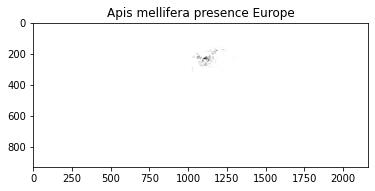

In [13]:
plt.imshow(presenceG['Apis_mellifera']['Europe'], cmap='binary')
plt.title("Apis mellifera presence Europe")

Text(0.5, 1.0, 'Apis mellifera absence Europe')

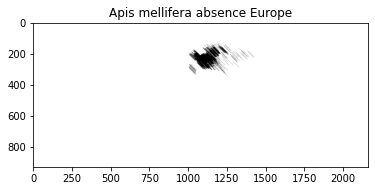

In [14]:
plt.imshow(absenceG['Apis_mellifera']['Europe'], cmap='binary')
plt.title("Apis mellifera absence Europe")

Now we want to extract the WORLDCLIM data for these points and save it - just like we did for the presence points.

We only need absence points for the current data (I think) and then we can predict presence and absence under the predicted scenarios using the SDM.

In [15]:
# get the names of the bioclim datapoints

bioclim = pd.read_csv(file_path + "bioclim.tsv", sep="\t")
bioclim_name = dict(zip(bioclim['variable_number'], bioclim['name']))

# set the paths to the raster files for current and predicted climate
raster_path_current = file_path + "climate_data/" + "near_present.tif"

# open the raster files
raster_current = rasterio.open(raster_path_current)

# convert the data into a matrix, round to 6dp, replace inf with nan
grid_current = raster_current.read()
grid_current = np.round(grid_current, 6)
grid_current[grid_current == float('-inf'), ] = float('nan')
# exclude very low latitudes
grid_current = grid_current[:, 0:930, :]


for species in species_list:
  all_results = pd.DataFrame()
  for continent in continents:
      if species in typeD:
        if os.path.exists(file_path + "species_plus_climate_observed_geo/" + species + ".tsv"):

            if continent in absenceD[species]:
                absence = absenceD[species][continent]
                raster_results = []
                # for each absence point
                for i, (x, y) in enumerate(zip(absence[0], absence[1])):
                    dLong, dLat = convert_xy_to_longlat(y, x)
                    this_obs = ["obs_" + str(i+1), x, y, dLong, dLat, continent]

                    # for each bioclim variable
                    for i in range(0, 19):
                        # get the grid for this variable
                        var_grid = grid_current[i]
                        
                        # get the value of this variable at this grid point
                        gridpoint_current = var_grid[x, y]
                        # store the results for this observation
                        this_obs.append(gridpoint_current)
                    # exclude NA values
                    if not np.isnan(this_obs[-1]):
                       raster_results.append(this_obs)
                # save everything in the species_plus_climate_observed_absence folder
                results = pd.DataFrame(raster_results, columns=['obs_ID', 'x', 'y', 'decimalLongitude', 'decimalLatitude', 'Continent'] + [bioclim_name[x] for x in range(1, 20)])
                all_results = all_results.append(results)
  all_results.to_csv(file_path + "species_plus_climate_observed_absence/" + species + "_geo.tsv", sep="\t", index=None)